In [215]:
import sys, os
from time import sleep, time
import numpy as np
codebase_dir = 'D:/ZiaLab/Codebase/'
sys.path.append(codebase_dir)
%reload_ext autoreload
%autoreload 2
%load_ext autotime
from zialab.instruments import madcity
from random import choice
from tqdm import tqdm
from matplotlib import pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 125 ms (started: 2024-03-13 19:44:02 -04:00)


In [226]:
stage = madcity.MadPiezo()


DLL Version:2.0
Stage is CONNECTED.
Handle:2

X_Range:302.671um, Y_Range:302.275um, Z_Range:302.81um
(149.93314190273347, 150.47960286650368, -0.035914555882405066)
time: 266 ms (started: 2024-03-13 19:49:49 -04:00)


In [225]:
stage.close()

Stage is DISCONNECTED.
Current Handles:0

time: 157 ms (started: 2024-03-13 19:49:45 -04:00)


In [221]:
stage.get_calibration()

X_Range:302.671um, Y_Range:302.275um, Z_Range:302.81um
time: 94 ms (started: 2024-03-13 19:48:14 -04:00)


In [228]:
stage.qPOS()

(149.94591376129398, 150.47290064364333, -0.04496247471212154)

time: 141 ms (started: 2024-03-13 19:49:55 -04:00)


In [227]:
stage.move('x', 150)
stage.move('y', 150)


time: 125 ms (started: 2024-03-13 19:49:53 -04:00)


In [120]:
stage.aux_clock() 

time: 0 ns (started: 2024-03-11 20:37:12 -04:00)


In [113]:
from zialab.softwarecontrol import lightfield
# from zialab.softwarecontrol import spe2py
lf = lightfield.LField()
lf_dir = lf.lf_dir
lf.pref_naming_settings()

time: 40.7 s (started: 2024-03-11 20:23:58 -04:00)


In [9]:
def rando_wiggle(step_size_in_um, xy_origin_in_mm, num_steps, bound_range=0, kind='unbounded'):
    '''
    Parameters
    ----------
    step_size_in_um (float)
    xy_origin_in_mm (tuple) (x0, y0)
    num_steps       (int) : how many regions the random walk has
    bound_range (int) : max displacement of random walk in each direction in steps (w.r.t origin)
    Returns
    -------
    walkSteps (np.array), walkString (str), walkTrajectory (np.array)
        walkSteps : has the incremental motions in units of the step size
        walkString : is a string representation of the incremental motions
        walkTrajectory : each row of this array represents the different positions (in mm) that the walk should visit
    '''

    step_size_in_mm = step_size_in_um/1000
    step_choices = [(1,0),(-1,0),(0,1),(0,-1)]
    walkSteps = [(0,0)]
    walkString = 'O'

    if kind == 'unbounded':

        for i in range(num_steps-1):
            rando_move = choice(step_choices)
            if rando_move == (1,0):
                walkString+= 'R'
            elif rando_move == (0,1):
                walkString += 'U'
            elif rando_move == (0,-1):
                walkString += 'D'
            elif rando_move ==  (-1,0):
                walkString += 'L'
            walkSteps.append(rando_move)
        
    
    if kind == 'bounded':
        total_steps_x = 0
        total_steps_y = 0
        for i in range(num_steps-1):
        
            while True:
                rando_move = choice(step_choices)

                if (np.abs(total_steps_x + rando_move[0]) <= bound_range) and (np.abs(total_steps_y + rando_move[1]) <= bound_range):
                    break
                    
            if rando_move == (1,0):
                walkString+= 'R'
            elif rando_move == (0,1):
                walkString += 'U'
            elif rando_move == (0,-1):
                walkString += 'D'
            elif rando_move ==  (-1,0):
                walkString += 'L'

            total_steps_x += rando_move[0] 
            total_steps_y += rando_move[1]      
            walkSteps.append(rando_move)

    walkSteps = np.array(walkSteps)
    walkTrajectory_in_mm = step_size_in_mm*np.cumsum(walkSteps,axis=0)
    walkTrajectory_in_mm = np.array(xy_origin_in_mm) + walkTrajectory_in_mm
    walkTrajectory_in_steps = np.cumsum(walkSteps,axis=0)
    return walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps


time: 0 ns (started: 2024-03-08 17:37:10 -05:00)


In [30]:
from time import sleep

time: 0 ns (started: 2024-03-08 18:30:11 -05:00)


In [52]:
import pickle

time: 0 ns (started: 2024-03-08 19:01:37 -05:00)


In [64]:
np.max(walkTrajectory_in_mm)

0.238

time: 0 ns (started: 2024-03-08 19:39:49 -05:00)


In [68]:
# Step size changed to 4 um (20*2 = pixel size in 64x64 image, 40/10 = step size)
regions = [120, 90, 80, 70, 60, 50, 40, 30]
num_rando_walks = 3
num_rando_points = 500
rando_trajectory_directory = {}
the_experiments = {}
for region in regions:
    input("move micrometer to region %s lp/mm" % region)
    for rando_type in ['bounded', 'unbounded']:
        print("Looking at region %d for a %s random walk" % (region, rando_type))
        experiment = {'num_random_walks': num_rando_walks,
                    'step_size_in_um': 4 ,
                    'xy_origin_in_mm': (.15, .15),
                    'num_steps': num_rando_points,
                    'data': [],
                    'walk_steps': [],
                    'walk_strings': [],
                    'walk_trajectories_in_int': [],
                    'walk_trajectories_in_mm': [],
                    'walk_kind': rando_type,
                    'walk_bound': 4}
        for i in range(experiment['num_random_walks']):
            while True:
                walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps = rando_wiggle(experiment['step_size_in_um'],
                                                                    experiment['xy_origin_in_mm'],
                                                                    experiment['num_steps'], bound_range=experiment['walk_bound'], kind=experiment['walk_kind'])
                if np.max(walkTrajectory_in_mm) < 0.3*0.95 and np.min(walkTrajectory_in_mm) > 0.3*0.05:
                    break
            if rando_type == 'unbounded':
                rando_trajectory_directory[i] = (walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps)
            experiment['walk_steps'].append(walkSteps)
            experiment['walk_strings'].append(walkString)
            experiment['walk_trajectories_in_mm'].append(walkTrajectory_in_mm)
            experiment['walk_trajectories_in_int'].append(walkTrajectory_in_steps)
        experiment_fname = 'big-expedition-%d-%s.pkl' % (region, rando_type)
        pickle.dump(experiment, open(experiment_fname, 'wb'))
        the_experiments[(region, rando_type)] = experiment
        #Name the file that holds the integer trajectories 
        with open('08MAR2024_walk_trajectories-%d-%s.py' % (region, rando_type),'w') as file:
            file.write('coords='+str(list(map(lambda x: x.tolist(), np.array(experiment['walk_trajectories_in_int'])))))
        trajectories_in_mm  = experiment['walk_trajectories_in_mm']
        trajectories_in_int = experiment['walk_trajectories_in_int']
        for rando_walk_index in range(experiment['num_random_walks']):
            fname = "rando-walk-step-and-move-%d-%s-%d" % (region, rando_type, rando_walk_index)
            lf.set_filename(fname, timetag = False)
            input("click acquire on LF")
            single_walk_dictionary = {}
            trajectory_in_mm = trajectories_in_mm[rando_walk_index]
            trajectory_in_int = trajectories_in_int[rando_walk_index]
            #Bring the stage to the starting position, then send an aux clock pulse and proceed with the rest of the steps
            commanded_position_in_mm = trajectory_in_mm[0]
            commanded_position_in_int = tuple(trajectory_in_int[0])
            x, y = commanded_position_in_mm*1000
            stage.move('x', x)
            stage.move('y', y)
            stage.aux_clock()
            for trajectory_index in tqdm(range(1, experiment['num_steps'])):
                commanded_position_in_mm = trajectory_in_mm[trajectory_index]
                commanded_position_in_int = tuple(trajectory_in_int[trajectory_index])
                # command the stage to move to commanded_position_in_mm
                x, y = commanded_position_in_mm*1000 #Made these values in um
                stage.move('x', x)
                stage.move('y', y)
            stage.aux_clock()
            print("acq finished...")
            sleep(5)

Looking at region 120 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.48it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.52it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.53it/s]


acq finished...
Looking at region 120 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.61it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.48it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.63it/s]


acq finished...
Looking at region 90 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.87it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.49it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.72it/s]


acq finished...
Looking at region 90 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.62it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.47it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.77it/s]


acq finished...
Looking at region 80 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.77it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.45it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.58it/s]


acq finished...
Looking at region 80 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.65it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.67it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.66it/s]


acq finished...
Looking at region 70 for a bounded random walk


100%|██████████| 499/499 [00:16<00:00, 31.16it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.57it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.61it/s]


acq finished...
Looking at region 70 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.41it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.70it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.60it/s]


acq finished...
Looking at region 60 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.33it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.64it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.74it/s]


acq finished...
Looking at region 60 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.37it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.61it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.68it/s]


acq finished...
Looking at region 50 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.67it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.40it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.43it/s]


acq finished...
Looking at region 50 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.67it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.41it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.56it/s]


acq finished...
Looking at region 40 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.46it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.35it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.74it/s]


acq finished...
Looking at region 40 for a unbounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.48it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.65it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.41it/s]


acq finished...
Looking at region 30 for a bounded random walk


100%|██████████| 499/499 [00:15<00:00, 31.42it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.75it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.60it/s]


acq finished...
Looking at region 30 for a unbounded random walk


100%|██████████| 499/499 [00:16<00:00, 30.91it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.53it/s]


acq finished...


100%|██████████| 499/499 [00:15<00:00, 31.63it/s]


acq finished...
Looking at region 120 for a unbounded random walk


IndexError: invalid index

time: 33min 57s (started: 2024-03-08 19:43:31 -05:00)


In [81]:
for region in regions:
    input("move micrometer to region %s lp/mm" % region)
    print("Looking at region %d for a %s random walk" % (region, 'unbounded'))
    experiment = the_experiments[(region, 'unbounded')]
    trajectories_in_mm  = experiment['walk_trajectories_in_mm']
    trajectories_in_int = experiment['walk_trajectories_in_int']
    input("adjust brightness for faster readout, and take background sub ...")
    for i in range(experiment['num_random_walks']):
        fname = 'continous-%d-%d' % (region, i)
        lf.set_filename(fname, timetag = False)
        input("click Acquire in LF ...")
        walkTrajectory_in_mm = trajectories_in_mm[i]
        waveformx = walkTrajectory_in_mm[:,0] * 1000
        waveformy = walkTrajectory_in_mm[:,1] * 1000
        waveformz = [0]*num_rando_points
        stage.move('x', waveformx[0])
        stage.move('y', waveformy[0])
        stage.setup_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points, dwell_time=6, iterations=1)
        x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points)
        fname = 'continuous-random-unbounded-%d-%d.csv' % (region, i)
        np.savetxt(fname, np.array([x,y]).T, delimiter=',')
        sleep(5)

Looking at region 120 for a unbounded random walk
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Looking at region 90 for a unbounded random walk
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Looking at region 80 for a unbounded random walk
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Looking at region 70 for a unbounded random walk
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-ax

In [177]:
'''
waveformx_extend = []
waveformy_extend = []
for i in range(len(waveformx)-1):
    for tt in range(40):
            xx = waveformx[i]*(39-tt)/39 + waveformx[i+1]*(tt)/39
            yy = waveformy[i]*(39-tt)/39 + waveformy[i+1]*(tt)/39
            waveformx_extend.append(xx)
            waveformy_extend.append(yy)

'''

waveformx_extend = []
for i in range(len(waveformx)):
    for _ in range(40):
        waveformx_extend.append(waveformx[i])


waveformy_extend = []
for i in range(len(waveformx)):
    for _ in range(40):
        waveformy_extend.append(waveformy[i])
#'''

waveformx_extend = waveformx_extend[0:1500]
waveformy_extend = waveformy_extend[0:1500]

num_points = len(waveformy_extend)

waveformz = [0]*num_points
stage.move('x', waveformx_extend[0])
stage.move('y', waveformy_extend[0])
stage.setup_wfma(waveformx_extend, waveformy_extend, waveformz, npoints = num_points, dwell_time=6, iterations=1)
x,y,z = stage.trigger_read_wfma(waveformx_extend, waveformy_extend, waveformz, npoints = num_points)
#fname = 'continuous-%d-%d-slow.csv' % (region, 2)
#np.savetxt(fname, np.array([x,y]).T, delimiter=',')

Multi-axis waveform SET.
Multi-axis waveform triggered and running...
time: 3.2 s (started: 2024-03-12 13:44:12 -04:00)


In [100]:
waveformx_extend = []
for i in range(len(waveformx)):
    for _ in range(10):
        waveformx_extend.append(waveformx[i])



time: 16 ms (started: 2024-03-11 20:06:36 -04:00)


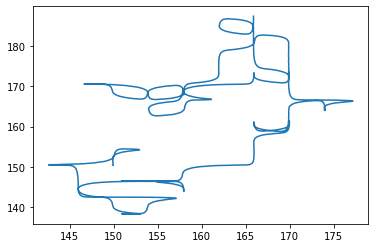

time: 172 ms (started: 2024-03-11 21:36:06 -04:00)


In [168]:
plt.plot(x[:2000], y[:2000],)
plt.show()

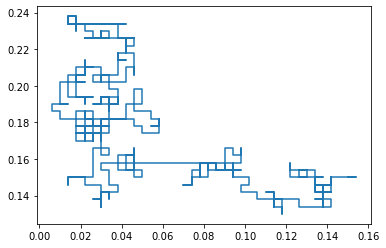

time: 250 ms (started: 2024-03-08 19:36:29 -05:00)


In [62]:
plt.plot(walkTrajectory_in_mm[:,0], walkTrajectory_in_mm[:,1])
plt.show()

In [61]:
walkTrajectory_in_mm

array([[0.15 , 0.15 ],
       [0.146, 0.15 ],
       [0.15 , 0.15 ],
       [0.154, 0.15 ],
       [0.15 , 0.15 ],
       [0.146, 0.15 ],
       [0.142, 0.15 ],
       [0.142, 0.146],
       [0.138, 0.146],
       [0.142, 0.146],
       [0.142, 0.15 ],
       [0.142, 0.146],
       [0.142, 0.142],
       [0.138, 0.142],
       [0.138, 0.146],
       [0.134, 0.146],
       [0.134, 0.142],
       [0.138, 0.142],
       [0.138, 0.138],
       [0.142, 0.138],
       [0.142, 0.134],
       [0.138, 0.134],
       [0.138, 0.138],
       [0.138, 0.142],
       [0.142, 0.142],
       [0.138, 0.142],
       [0.134, 0.142],
       [0.134, 0.146],
       [0.134, 0.15 ],
       [0.138, 0.15 ],
       [0.134, 0.15 ],
       [0.138, 0.15 ],
       [0.134, 0.15 ],
       [0.134, 0.154],
       [0.13 , 0.154],
       [0.126, 0.154],
       [0.126, 0.15 ],
       [0.13 , 0.15 ],
       [0.13 , 0.154],
       [0.13 , 0.15 ],
       [0.13 , 0.154],
       [0.126, 0.154],
       [0.122, 0.154],
       [0.1

time: 0 ns (started: 2024-03-08 19:34:50 -05:00)


In [87]:
# getting background for discrete random walk
# one file for all of them
bkg_fname = 'discrete-random-bkg.spe'
print(bkg_fname)
input("click acquire on LF for bkg file ...")
single_walk_dictionary = {}
trajectory_in_mm  = trajectories_in_mm[0]
trajectory_in_int = trajectories_in_int[0]
# Bring the stage to the starting position, then send an aux clock pulse and proceed with the rest of the steps
commanded_position_in_mm = trajectory_in_mm[0]
commanded_position_in_int = tuple(trajectory_in_int[0])
for _ in range(6):
    x, y = commanded_position_in_mm*1000
    stage.move('x', x)
    stage.move('y', y)

    stage.aux_clock()
    for trajectory_index in tqdm(range(1, experiment['num_steps'])):
        commanded_position_in_mm = trajectory_in_mm[trajectory_index]
        commanded_position_in_int = tuple(trajectory_in_int[trajectory_index])
        # command the stage to move to commanded_position_in_mm
        x, y = commanded_position_in_mm*1000 #Made these values in um
        stage.move('x', x)
        stage.move('y', y)
    stage.aux_clock()
    sleep(0.01)
stage.aux_clock()
stage.aux_clock()
stage.aux_clock()
print("acq finished...")
#sleep(5)

discrete-random-bkg.spe


100%|██████████| 499/499 [00:15<00:00, 31.58it/s]

acq finished...
time: 1min 51s (started: 2024-03-08 20:48:20 -05:00)


In [89]:
stage.aux_clock()

time: 16 ms (started: 2024-03-08 20:50:26 -05:00)


In [181]:
stage.qPOS()

(149.94277491395033, 150.4959980933824, -0.03570655749575434)

time: 0 ns (started: 2024-03-12 13:53:59 -04:00)


In [182]:
#Bounded Random Walks (Larger Bounds) with Readout 

# Step size changed to 4 um (20*2 = pixel size in 64x64 image, 40/10 = step size)
regions = [30]
num_rando_walks = 3
num_rando_points = 1500
rando_trajectory_directory = {}
the_experiments = {}
for region in regions:
    input("move micrometer to region %s lp/mm" % region)
    for rando_type in ['bounded']:
        print("Looking at region %d for a %s random walk" % (region, rando_type))
        experiment = {'num_random_walks': num_rando_walks,
                    'step_size_in_um': 4 ,
                    'xy_origin_in_mm': (.15, .15),
                    'num_steps': num_rando_points,
                    'data': [],
                    'walk_steps': [],
                    'walk_strings': [],
                    'walk_trajectories_in_int': [],
                    'walk_trajectories_in_mm': [],
                    'walk_kind': rando_type,
                    'walk_bound': 8}
        for i in range(experiment['num_random_walks']):
            while True:
                walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps = rando_wiggle(experiment['step_size_in_um'],
                                                                    experiment['xy_origin_in_mm'],
                                                                    experiment['num_steps'], bound_range=experiment['walk_bound'], kind=experiment['walk_kind'])
                if np.max(walkTrajectory_in_mm) < 0.3*0.95 and np.min(walkTrajectory_in_mm) > 0.3*0.05:
                    break
            if rando_type == 'bounded':
                rando_trajectory_directory[i] = (walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps)
            experiment['walk_steps'].append(walkSteps)
            experiment['walk_strings'].append(walkString)
            experiment['walk_trajectories_in_mm'].append(walkTrajectory_in_mm)
            experiment['walk_trajectories_in_int'].append(walkTrajectory_in_steps)
        experiment_fname = 'bounded-continuous-%d-%s.pkl' % (region, rando_type)
        pickle.dump(experiment, open(experiment_fname, 'wb'))
        the_experiments[(region, rando_type)] = experiment
        #Name the file that holds the integer trajectories 
        with open('12MAR2024_walk_trajectories-%d-%s.py' % (region, rando_type),'w') as file:
            file.write('coords='+str(list(map(lambda x: x.tolist(), np.array(experiment['walk_trajectories_in_int'])))))
        trajectories_in_mm  = experiment['walk_trajectories_in_mm']
        trajectories_in_int = experiment['walk_trajectories_in_int']

        for i in range(experiment['num_random_walks']):
            fname = 'bounded-continous-%d-%d' % (region, i)
            lf.set_filename(fname, timetag = False)
            input("click Acquire in LF ...")
            walkTrajectory_in_mm = trajectories_in_mm[i]
            waveformx = walkTrajectory_in_mm[:,0] * 1000
            waveformy = walkTrajectory_in_mm[:,1] * 1000
            waveformz = [0]*num_rando_points
            stage.move('x', waveformx[0])
            stage.move('y', waveformy[0])
            stage.setup_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points, dwell_time=6, iterations=1)
            x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points)
            fname1 = 'continuous-random-bounded-%d-%d-x.pkl' % (region, i)
            fname2 = 'continuous-random-bounded-%d-%d-y.pkl' % (region, i)
            
            pickle.dump(x, open(fname1,'wb'))
            pickle.dump(y, open(fname2,'wb'))
            
            sleep(5)

Looking at region 30 for a bounded random walk
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
time: 1min 7s (started: 2024-03-12 13:55:58 -04:00)


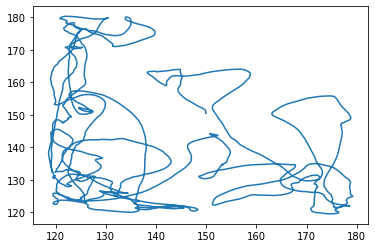

time: 172 ms (started: 2024-03-12 14:09:35 -04:00)


In [186]:
plt.plot(x,y)


In [173]:
#Aquire Background 

#bkg_fname = 'continuous-random-bkg.spe'
bkg_fname = 'continuous-random-bounded-bkg.spe'
print(bkg_fname)
input("click Acquire in LF for bacground file ...")
walkSteps, walkString, walkTrajectory_in_mm, walkTrajectory_in_steps = rando_trajectory_directory[0]
waveformx = walkTrajectory_in_mm[:,0] * 1000
waveformy = walkTrajectory_in_mm[:,1] * 1000
waveformz = [0]*num_rando_points
for _ in range(6):
    stage.move('x', waveformx[0])
    stage.move('y', waveformy[0])
    stage.setup_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points, dwell_time=6, iterations=1)
    x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints = num_rando_points)
    sleep(0.01)

continuous-random-bkg.spe


Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
time: 10.8 s (started: 2024-03-12 12:40:31 -04:00)


In [184]:
#Aquire Ground Truth

#Exposure 0: 2969 ms
#Exposure 1: 2982 ms
#Exposure 2: 2971 ms

stage.move('x', 150)
stage.move('y', 150)

stage.qPOS()

#Average: 2974 ms

#Check exposure time of aquisitions

(149.9561601169591, 150.47156740587627, -0.03958919216800541)

time: 31 ms (started: 2024-03-12 14:02:59 -04:00)


In [185]:
np.average([2969, 2982, 2971])

2974.0

time: 0 ns (started: 2024-03-12 14:03:54 -04:00)


In [ ]:
waveformx = [150]*1000
waveformy = [150]*1000
waveformz = [0]*1000

waveformx = walkTrajectory_in_mm[:,0] * 1000
waveformy = walkTrajectory_in_mm[:,1] * 1000
waveformz = [0]*500

#stage.aux_clock()
stage.setup_wfma(waveformx, waveformy, waveformz, npoints=500, dwell_time=6,iterations=1)
x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints=500)

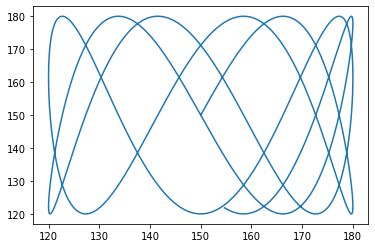

time: 281 ms (started: 2024-03-14 16:31:25 -04:00)


In [305]:
f1 = 0.4
f2 = 1.1
num_points = 1500
theta = np.linspace(0, 3*np.pi * f2/f1 * 1.5, num_points)
x_liss = 30*np.sin(f1 * theta) + 150
y_liss = 30*np.sin(f2 * theta) + 150
plt.figure()
plt.plot(x_liss,y_liss)
plt.show()

In [306]:
1.1/0.4

2.75

time: 125 ms (started: 2024-03-14 16:31:51 -04:00)


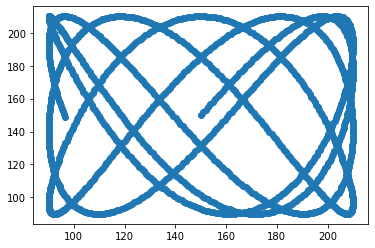

time: 250 ms (started: 2024-03-14 16:17:22 -04:00)


In [281]:
f3 = 1
f4 = 1.7
num_points = 1500
theta = np.linspace(0, 3*np.pi * f4/f3 * 1.5, num_points)
x_liss = 60*np.sin(f3 * theta) + 150
y_liss = 60*np.sin(f4 * theta) + 150
plt.figure()
plt.plot(x_liss,y_liss, marker='o')
plt.show()

In [324]:
from PrincetonInstruments.LightField.AddIns import *

time: 141 ms (started: 2024-03-15 16:34:05 -04:00)


In [323]:
CameraSettings

PrincetonInstruments.LightField.AddIns.CameraSettings

time: 109 ms (started: 2024-03-15 16:33:56 -04:00)


In [319]:
trigger_responses = {
    'Readout Per Trigger': 2,
    'No Response': 1,
    'Start On Single Trigger': 5,
    'Shift Per Trigger': 3,
    'Expose During Trigger Pulse': 4}

time: 94 ms (started: 2024-03-15 16:33:01 -04:00)


In [ ]:
lf.set_trigger_response('Expose During Trigger Pulse')

In [326]:
lf.acquire()

time: 7.22 s (started: 2024-03-15 16:37:45 -04:00)


In [ ]:
lf.background_subraction_off()

In [ ]:
lf.background_subraction_on()

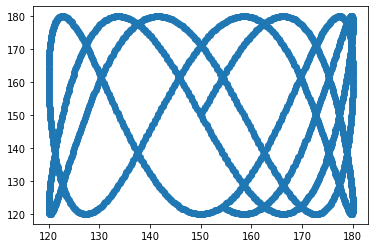

time: 328 ms (started: 2024-03-14 16:53:17 -04:00)


In [308]:
f3 = 0.4
f4 = 1.1
num_points = 1500
theta = np.linspace(0, 3*np.pi * f2/f1 * 1.5, num_points)
x_liss = 30*np.sin(f1 * theta) + 150
y_liss = 30*np.sin(f2 * theta) + 150
plt.figure()
plt.plot(x_liss,y_liss, marker='o')
plt.show()

In [309]:
stage.qPOS()

(149.9407184280201, 150.47063053612763, -0.03688521486727163)

time: 109 ms (started: 2024-03-14 16:53:41 -04:00)


In [310]:
f_ratio = f4/f3
f_ratio

2.75

time: 94 ms (started: 2024-03-14 16:54:09 -04:00)


Multi-axis waveform SET.
Multi-axis waveform triggered and running...


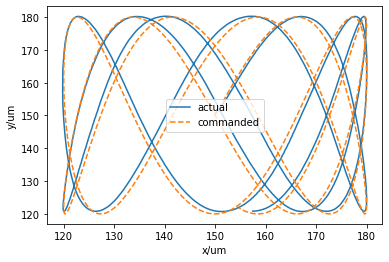

time: 3.61 s (started: 2024-03-14 16:54:54 -04:00)


In [311]:
waveformx = x_liss
waveformy = y_liss
waveformz = [0]*len(x_liss)
runs_x = []
runs_y = []

stage.move('x', waveformx[0])
stage.move('y', waveformy[0])
stage.setup_wfma(waveformx, waveformy, waveformz, npoints=1500, dwell_time=6,iterations=1)
x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints=1500)
runs_x = x
runs_y = y

region = 30
f_ratio = f4/f3
fname1 = 'vibration-%d-%.1f-x.pkl' % (region, f_ratio)
fname2 = 'vibration-%d-%.1f-y.pkl' % (region, f_ratio)

pickle.dump(x, open(fname1,'wb'))
pickle.dump(y, open(fname2,'wb'))

plt.plot(runs_x,runs_y,label='actual')
plt.plot(x_liss,y_liss,'--', label='commanded')
plt.legend()
plt.xlabel('x/um')
plt.ylabel('y/um')
plt.show()



In [318]:
'vibration-%d-%.2f-x.pkl' % (region, f_ratio)

'vibration-30-2.75-x.pkl'

time: 109 ms (started: 2024-03-14 16:58:41 -04:00)


In [312]:
#Vibration Background Acquisition

waveformx = x_liss
waveformy = y_liss
waveformz = [0]*len(x_liss)

for _ in range(6):
    stage.move('x', waveformx[0])
    stage.move('y', waveformy[0])
    stage.setup_wfma(waveformx, waveformy, waveformz, npoints=1500, dwell_time=6,iterations=1)
    x,y,z = stage.trigger_read_wfma(waveformx, waveformy, waveformz, npoints=1500)
    sleep(0.1)

Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
Multi-axis waveform SET.
Multi-axis waveform triggered and running...
time: 20 s (started: 2024-03-14 16:55:31 -04:00)


In [314]:
#Check Exposure Time for Vibration and set as exposure time for GT 

stage.move('x', 150)
stage.move('y', 150)

stage.qPOS()

#2986 ms
#3000 ms
#2979 ms

(149.9476816180636, 150.48140453950037, -0.031477254522615426)

time: 125 ms (started: 2024-03-14 16:55:57 -04:00)
